# Hurricane Sandy Event Study: U.S. Market and Sectors

In [1]:
!pip install yfinance

import numpy as np

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from utils import *

In [3]:
# Download SPY data (Yahoo Finance)
ticker = "SPY"

myindex = yf.download(ticker, start=SANDY_START_DATE, end=SANDY_END_DATE)
print(myindex.columns)

# Extract 'Adj Close' or fallback to 'Close'
if isinstance(myindex.columns, pd.MultiIndex):
    # Flatten MultiIndex columns
    myindex.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in myindex.columns]
    adj_col = [col for col in myindex.columns if 'Adj Close' in col or 'Close' in col][0]
else:
    adj_col = 'Adj Close' if 'Adj Close' in vnindex.columns else 'Close'

myindex = myindex[[adj_col]].rename(columns={adj_col: 'SPYINDEX'})
myindex.index = pd.to_datetime(myindex.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


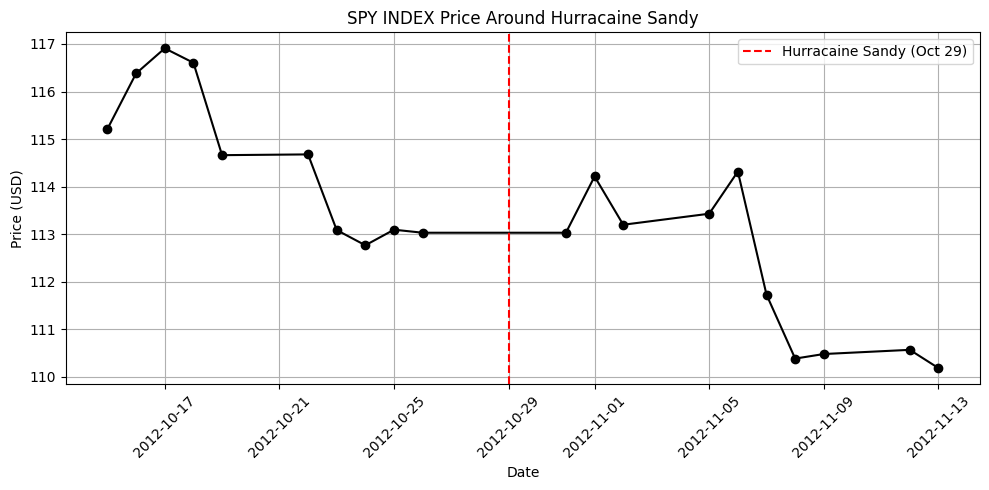

In [5]:
# Define event date: Hurracaine Samdey landfall
# Landfall: October 29, 2012

# Market days +/- 15 days
event_window_dates = myindex.loc[(myindex.index >= SANDY_DATE - timedelta(days=EVENT_WINDOW)) &
                                  (myindex.index <= SANDY_DATE + timedelta(days=EVENT_WINDOW))]

# Plot VNINDEX (VNM ETF) during the event window
plt.figure(figsize=(10, 5))
plt.plot(event_window_dates.index, event_window_dates['SPYINDEX'], marker='o', color='black')
plt.axvline(SANDY_DATE, color='red', linestyle='--', label='Hurracaine Sandy (Oct 29)')
plt.title("SPY INDEX Price Around Hurracaine Sandy")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Abnormal Returns (AR)** tells how much a stock’s return deviates from “normal” on a given day. This is important to quantify because it isolates the effect of a specific event (e.g., Typhoon Damrey) from regular market movements. Here we're asking: Did something unusual happen to the stock because of this event?

* Normal return = what we would expect based on historical behavior (e.g., average return).

* AR$_t$ = Actual Return$_t$−Expected Return$_t$

In [6]:
# Calculate daily returns and abnormal returns
# The first row is expected to be NaN
myindex['return'] = myindex['SPYINDEX'].pct_change()
mean_return = myindex['return'].mean()
myindex['abnormal_return'] = myindex['return'] - mean_return
myindex.head(15)

,SPYINDEX,return,abnormal_return
Date,,,
2012-10-01,115.429085,NaN,NaN
2012-10-02,115.548988,0.001039,0.001393
2012-10-03,116.020782,0.004083,0.004438
2012-10-04,116.852402,0.007168,0.007522
2012-10-05,116.860458,0.000069,0.000423
2012-10-08,116.460648,-0.003421,-0.003067
2012-10-09,115.309143,-0.009887,-0.009533
2012-10-10,114.573395,-0.006381,-0.006026
2012-10-11,114.637436,0.000559,0.000914


**Cumulative Abnormal Return (CAR)** is the sum of abnormal returns over a window of days, usually around the event (e.g., -15 to +15 days).

CAR$_{[t_1,t_2]}$=$\sum_{t=t_1}^{t_2}$AR$_t$

This is an important quantity because it captures the total market impact of the event. A negative CAR suggests investors reacted negatively to the event, while a positive one suggests a favorable or resilient response.

              SPYINDEX    return  abnormal_return       CAR
Date                                                       
2012-10-15  115.213142  0.008327         0.008682  0.008682
2012-10-16  116.380653  0.010133         0.010488  0.019170
2012-10-17  116.908424  0.004535         0.004889  0.024059
2012-10-18  116.604568 -0.002599        -0.002245  0.021815
2012-10-19  114.661423 -0.016664        -0.016310  0.005505


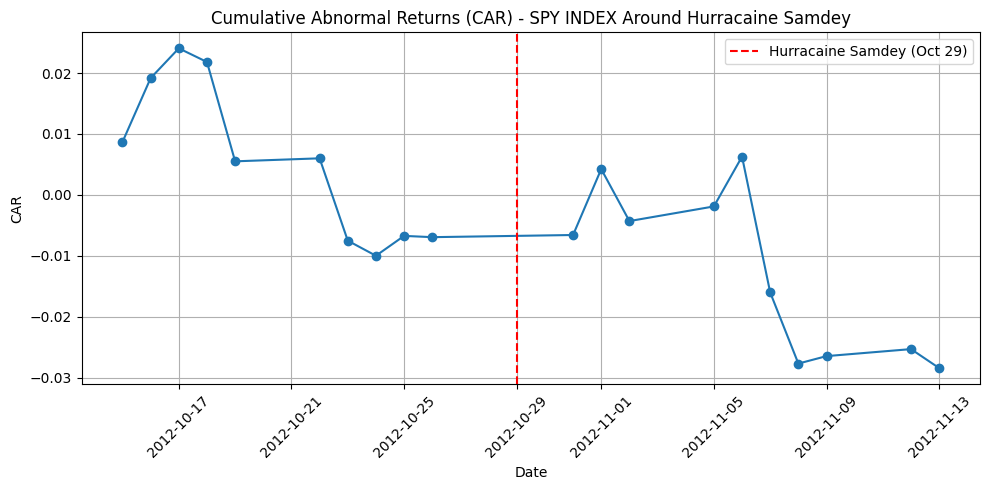

In [7]:
# Extract event window data
window_data = myindex.loc[event_window_dates.index]
window_data['CAR'] = window_data['abnormal_return'].cumsum()
print(window_data.head())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(window_data.index, window_data['CAR'], marker='o')
plt.axvline(SANDY_DATE, color='red', linestyle='--', label='Hurracaine Samdey (Oct 29)')
plt.title("Cumulative Abnormal Returns (CAR) - SPY INDEX Around Hurracaine Samdey")
plt.xlabel("Date")
plt.ylabel("CAR")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There's no clear significant behaviour that points to an obvious downturn of the market -- the trend was already down. We'll explore specific sectors.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


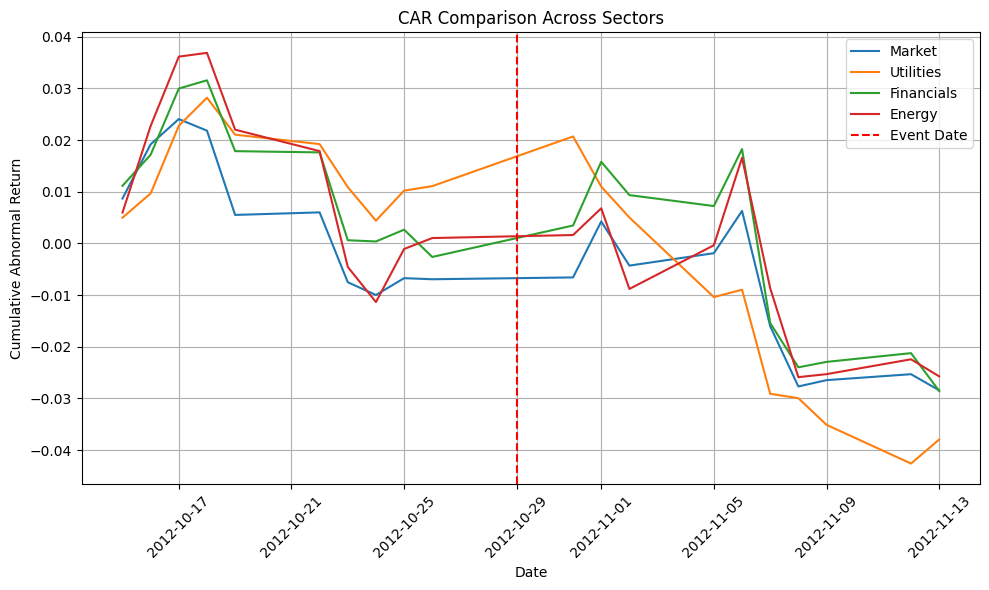

,Market,Utilities,Financials,Energy
Date,,,,
2012-10-15,0.008682,0.004977,0.011144,0.005962
2012-10-16,0.019170,0.009663,0.017156,0.022730
2012-10-17,0.024059,0.022762,0.029966,0.036146
2012-10-18,0.021815,0.028193,0.031564,0.036875
2012-10-19,0.005505,0.021041,0.017851,0.022007


In [8]:
# Sector Comparison CAR

sector_tickers = {
    "SPY": "Market",
    "XLU": "Utilities",
    "XLF": "Financials",
    "XLE": "Energy",
}

sector_results = compute_sector_cars(sector_tickers, SANDY_START_DATE, SANDY_END_DATE, SANDY_DATE)
plot_car_comparison(sector_results, SANDY_DATE)
sector_results.head()

The utilities sector was below the market, which is kind of the opposite of what I would expect (?)

## Weather plots
We'll use Visual Crossing to get NYC weather data around the dates of Hurricaine Samdey. NOAA/NCEI might be more accurate but Visual Crossing Rest API can be easily to scripted so we'll stick with that for a first pass.

In [9]:
import pandas as pd
from datetime import datetime
import urllib.parse

# Define parameters
api_key = "MY_API_KEY"
location = "New York,NY,USA"
start_date = "2012-10-01"
end_date = "2012-11-30"
unit_group = "metric"  # use "us" for Fahrenheit, "metric" for Celsius

# Encode location for URL
encoded_location = urllib.parse.quote(location)

# Construct download URL
# Use visual crossing API
url = (
    f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
    f"{encoded_location}/{start_date}/{end_date}"
    f"?unitGroup={unit_group}&key={api_key}&include=days&contentType=csv"
)

# Download and load into DataFrame
weather_df = pd.read_csv(url, parse_dates=["datetime"])
weather_df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York, NY, United States",2012-10-01,21.4,12.0,16.6,21.4,12.0,16.6,8.2,58.8,...,NaN,NaN,NaN,2012-10-01T06:52:56,2012-10-01T18:37:24,0.55,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
1,"New York, NY, United States",2012-10-02,20.4,17.0,17.9,20.4,17.0,17.9,13.4,77.1,...,NaN,NaN,NaN,2012-10-02T06:53:57,2012-10-02T18:35:45,0.58,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
2,"New York, NY, United States",2012-10-03,22.8,17.2,19.6,22.8,17.2,19.6,18.5,93.8,...,NaN,NaN,NaN,2012-10-03T06:54:59,2012-10-03T18:34:06,0.61,Overcast,Cloudy skies throughout the day.,cloudy,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
3,"New York, NY, United States",2012-10-04,23.1,20.1,21.4,23.1,20.1,21.4,19.6,89.4,...,NaN,NaN,NaN,2012-10-04T06:56:00,2012-10-04T18:32:27,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
4,"New York, NY, United States",2012-10-05,25.9,17.2,21.0,25.9,17.2,21.0,14.5,69.1,...,NaN,NaN,NaN,2012-10-05T06:57:02,2012-10-05T18:30:50,0.68,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."


In [10]:
# Ensure window_df is a DataFrame by converting the Series
window_df = sector_results[['Market']].copy()
print(window_df.head())

# Align column name in weather_df
print(weather_df.head())

              Market
Date                
2012-10-15  0.008682
2012-10-16  0.019170
2012-10-17  0.024059
2012-10-18  0.021815
2012-10-19  0.005505
                          name   datetime  tempmax  tempmin  temp  \
0  New York, NY, United States 2012-10-01     21.4     12.0  16.6   
1  New York, NY, United States 2012-10-02     20.4     17.0  17.9   
2  New York, NY, United States 2012-10-03     22.8     17.2  19.6   
3  New York, NY, United States 2012-10-04     23.1     20.1  21.4   
4  New York, NY, United States 2012-10-05     25.9     17.2  21.0   

   feelslikemax  feelslikemin  feelslike   dew  humidity  ...  solarenergy  \
0          21.4          12.0       16.6   8.2      58.8  ...          NaN   
1          20.4          17.0       17.9  13.4      77.1  ...          NaN   
2          22.8          17.2       19.6  18.5      93.8  ...          NaN   
3          23.1          20.1       21.4  19.6      89.4  ...          NaN   
4          25.9          17.2       21.0  14.5  

In [11]:
weather_df = weather_df.rename(columns={"datetime": "Date"})
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
weather_df.set_index("Date", inplace=True)

# Join on date
window_df = window_df.join(weather_df[["temp", "precip", "windspeed", "humidity", "sealevelpressure"]], how="left")

print(window_df.tail())

              Market  temp  precip  windspeed  humidity  sealevelpressure
Date                                                                     
2012-11-07 -0.016030   2.3  25.120       31.8      76.0            1012.5
2012-11-08 -0.027699   4.2   2.411       25.1      59.6            1008.8
2012-11-09 -0.026476   7.0   0.000       22.0      48.9            1017.6
2012-11-12 -0.025325  14.1   0.000       21.3      85.0            1028.4
2012-11-13 -0.028442   9.5   1.614       17.3      76.2            1025.5


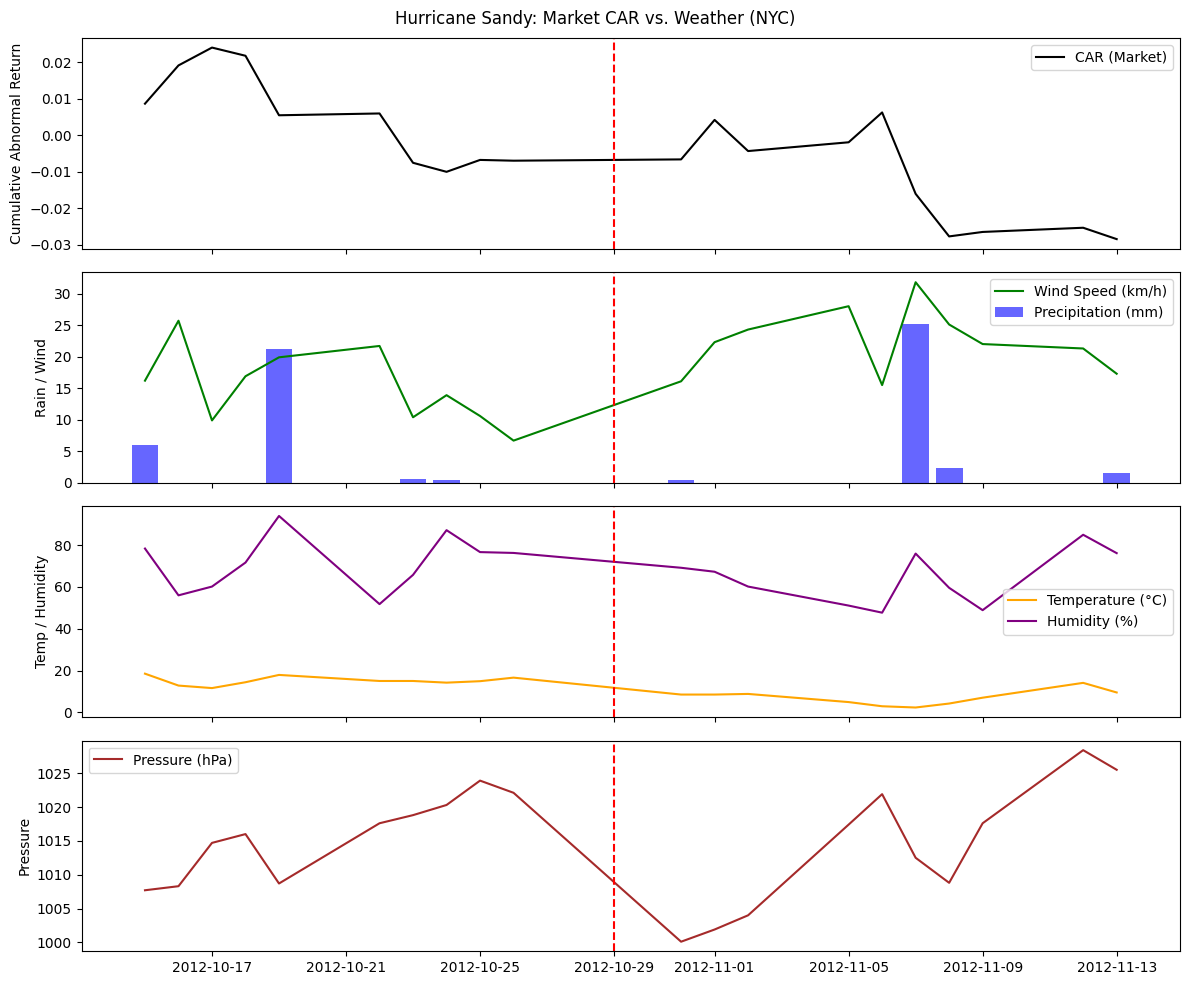

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

ax[0].plot(window_df.index, window_df['Market'], label='CAR (Market)', color='black')
ax[0].set_ylabel("Cumulative Abnormal Return")
ax[0].axvline(SANDY_DATE, color='red', linestyle='--')
ax[0].legend()

ax[1].bar(window_df.index, window_df['precip'], color='blue', alpha=0.6, label='Precipitation (mm)')
ax[1].plot(window_df.index, window_df['windspeed'], color='green', label='Wind Speed (km/h)')
ax[1].axvline(SANDY_DATE, color='red', linestyle='--')
ax[1].set_ylabel("Rain / Wind")
ax[1].legend()

ax[2].plot(window_df.index, window_df['temp'], label='Temperature (°C)', color='orange')
ax[2].plot(window_df.index, window_df['humidity'], label='Humidity (%)', color='purple')
ax[2].axvline(SANDY_DATE, color='red', linestyle='--')
ax[2].set_ylabel("Temp / Humidity")
ax[2].legend()

ax[3].plot(window_df.index, window_df['sealevelpressure'], label='Pressure (hPa)', color='brown')
ax[3].axvline(SANDY_DATE, color='red', linestyle='--')
ax[3].set_ylabel("Pressure")
ax[3].legend()

plt.suptitle("Hurricane Sandy: Market CAR vs. Weather (NYC)")
plt.tight_layout()
plt.show()